In [1]:
import tensorflow as tf
import numpy as np
import sys
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

/Users/alexmansano/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [3]:
train_data = mnist.train
test_data = mnist.test

In [4]:
#reincia o grafo sempre para o mesmo estado
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)

In [5]:
reset_graph()

inputs_dim = 28*28
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 200
n_hidden4 = 150
n_hidden5 = 100
n_hidden6 = n_hidden4
n_hidden7 = n_hidden3
n_hidden8 = n_hidden2
n_outputs = inputs_dim

learning_rate = 0.01

Note que adicionamos um ruído gaussiano ao valor da nossa entrada. Nosso autoencoder deve aprender a remover esse ruído

In [6]:
noise_level = 0.1

X = tf.placeholder(tf.float32, shape=[None, inputs_dim])
X_noisy = X + noise_level*tf.random_normal(tf.shape(X)) 

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=tf.nn.relu, name="hidden6")
hidden7 = tf.layers.dense(hidden6, n_hidden7, activation=tf.nn.relu, name="hidden7")
hidden8 = tf.layers.dense(hidden7, n_hidden8, activation=tf.nn.relu, name="hidden8")
outputs = tf.layers.dense(hidden8, inputs_dim, name="outputs") #linear defaul


reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))#MSE

In [7]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

In [8]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Trainamento

In [9]:
n_epochs = 2
batch_size = 150

In [10]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in tqdm.trange(n_batches, desc="batches"):
            X_batch, y_batch = train_data.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
        print("\r{}".format(epoch), "Reconstruction loss train: ", loss_train)
        print("\r{}".format(epoch), "Reconstruction loss test: ", loss_test)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")            

batches:  93%|█████████▎| 340/366 [00:09<00:00, 34.27it/s]/Users/alexmansano/anaconda/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
batches:   0%|          | 0/366 [00:00<?, ?it/s]

0 Reconstruction loss train:  0.04283071
0 Reconstruction loss test:  0.04297398


batches: 100%|██████████| 366/366 [00:14<00:00, 25.55it/s]


1 Reconstruction loss train:  0.034059804
1 Reconstruction loss test:  0.033254493


In [11]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis="off"

In [12]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_stacked_denoising_gaussian.ckpt")
    reconstructed_data = outputs.eval(feed_dict = {X: test_data.images})
    noisy_data = X_noisy.eval(feed_dict = {X: test_data.images})

INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_gaussian.ckpt


Vamos utilizar nosso conjunto de teste para verificarmos a capacidade do nosso autoencoder reconstruir um exemplo

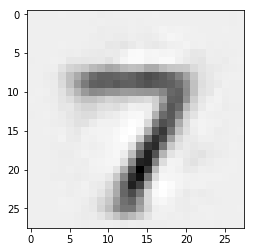

In [13]:
plot_image(reconstructed_data[0])

Abaixo temos a imagem com ruído

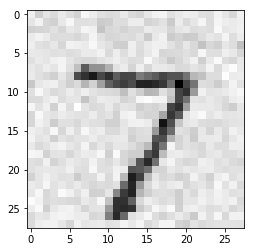

In [14]:
plot_image(noisy_data[0])

e a imagem original

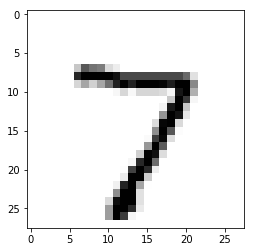

In [15]:
plot_image(mnist.test.images[0])

Vamos usar essa mesma imagem para vermos quais features nosso autoencoder aprender nas camadas mais baixas. Para isso precisamos obter os pesos da camada mais baixa.

In [16]:
def get_weights():
    return [v for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) 
            if v.name.endswith('kernel:0')] #obtem apenas os weights, ignorando bias

In [17]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_stacked_denoising_gaussian.ckpt")
    features1 = sess.run(get_weights())

INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_gaussian.ckpt


Abaixo podemos ver as features obtidas por 25 neurônios da primeira camada

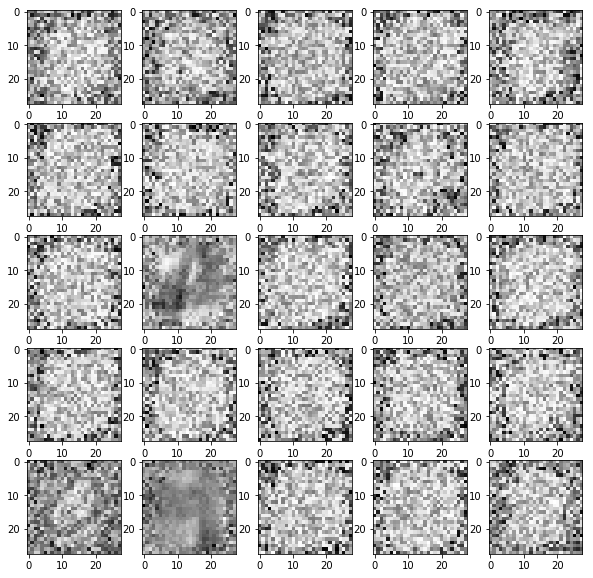

In [18]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plot_image(features1[0].T[i])
plt.show()

Agora podemos usar camadas deste modelo para treinarmos um classificador com menos dados

Vamos ver a estrutura do noss modelo

As camadas úteias para treinarmos um classificador são a 1 e 2

In [19]:
reset_graph()

inputs_dim = 28*28
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 200
n_hidden4 = 150
n_hidden5 = 100
n_hidden6 = 150
n_outputs = 10

In [20]:
X_train = mnist.train.images
Y_train = mnist.train.labels
X_test = mnist.test.images
Y_test = mnist.test.labels

In [21]:
X_train_selected = X_train[:5500] #10%
Y_train_selected = Y_train[:5500]

In [22]:
new_X = tf.placeholder(tf.float32, shape=[None, inputs_dim], name="new_X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [23]:
hidden1 = tf.layers.dense(new_X, n_hidden1, activation=tf.nn.relu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=tf.nn.relu, name="hidden6")
logits = tf.layers.dense(hidden6, n_outputs, activation=None, name="logits")


In [24]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

In [25]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [26]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[12345]")
restore_saver = tf.train.Saver(reuse_vars)

In [27]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[67]")
training_op = optimizer.minimize(loss, var_list=train_vars)

In [28]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [51]:
batch_size = 50
n_epochs = 400

In [52]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [53]:
from tensorflow.contrib.keras.api.keras.utils import Progbar
nbatches = len(X_train_selected) // batch_size

In [54]:
import time

In [58]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_stacked_denoising_gaussian.ckpt")
    
    for epoch in range(n_epochs):
        progbar = Progbar(target=nbatches, width=50)
        for X_batch, y_batch in shuffle_batch(X_train_selected, Y_train_selected, batch_size):
            sess.run(training_op, feed_dict={new_X: X_batch, y: y_batch})
            time.sleep(0.6)
            progbar.add(1)
        accuracy_test = accuracy.eval(feed_dict={new_X: X_test, y: Y_test})
        accuracy_train = accuracy.eval(feed_dict={new_X: X_train_selected, y: Y_train_selected})
        print(epoch, "Test accuracy:", accuracy_test, "Train accuracy:", accuracy_train)
9    
    save_path = saver.save(sess, "./my_model_classifier_with_autoencoder.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_gaussian.ckpt
110/110 [==================================================] - 67s    
0 Test accuracy: 0.7831 Train accuracy: 0.78581816
 11/110 [====>.............................................] - ETA: 60s

KeyboardInterrupt: 

In [22]:
d = {'a': 4, 'b': 1, 'c': 2}

In [24]:
sorted(d.values())

[1, 2, 4]